# Model Project

Import and set magics:

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1

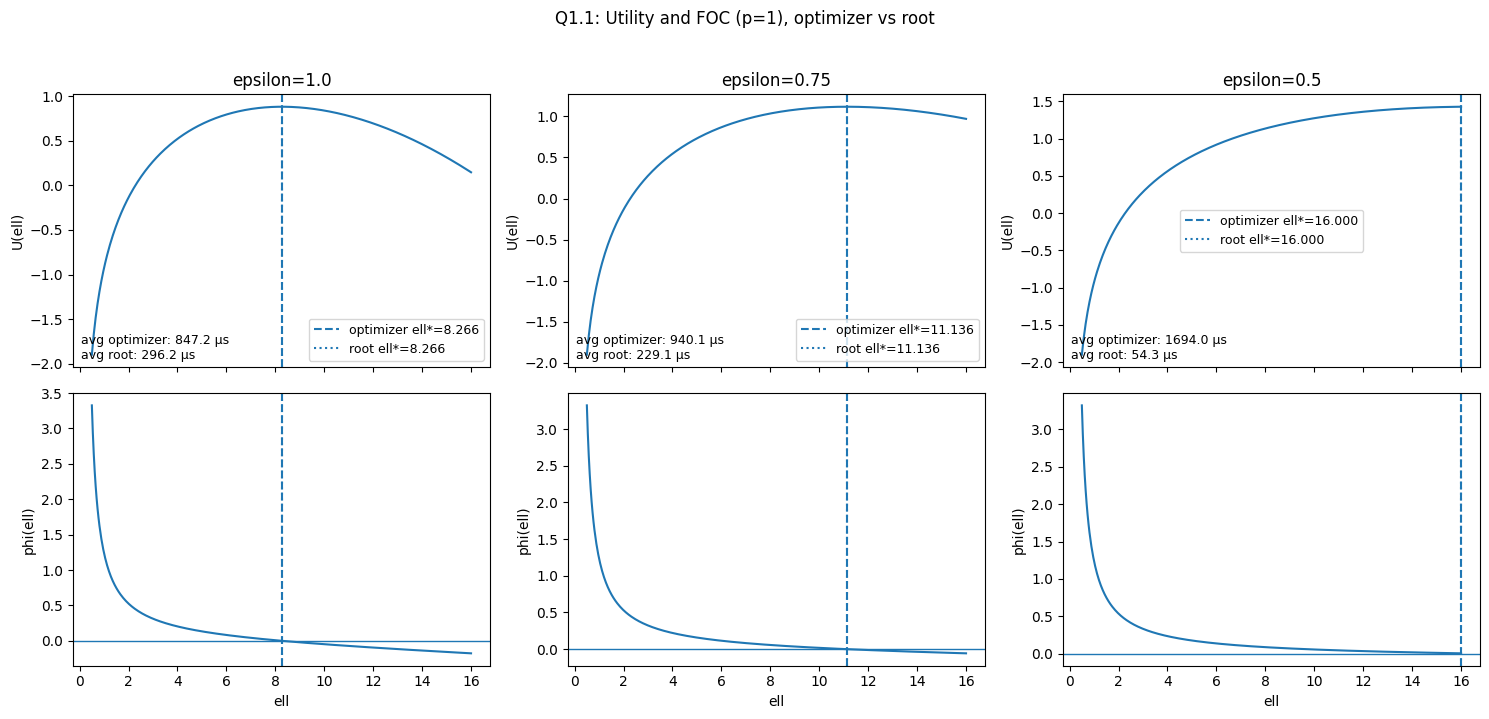

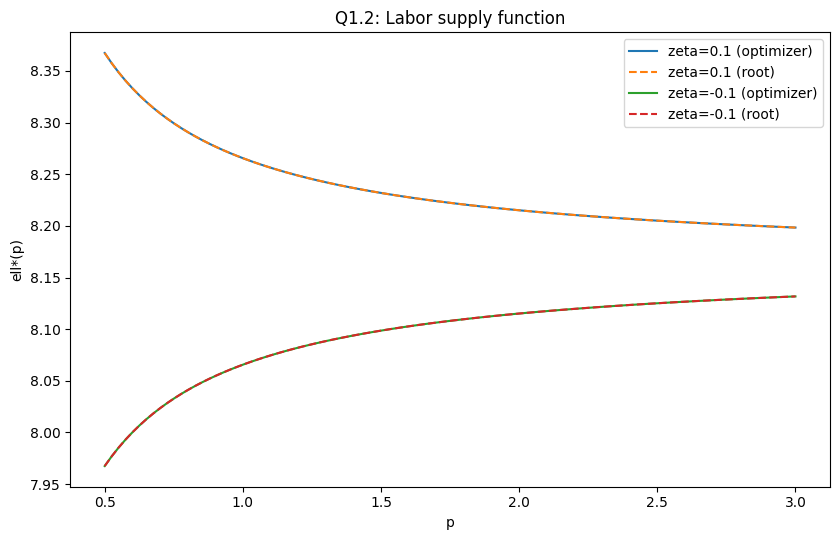

In [16]:
# ONE-CELL SOLUTION: WorkerSolved class + Q1.1 and Q1.2 runs
# (Does NOT require importing Worker.py)

from types import SimpleNamespace
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, root_scalar


class WorkerSolved:
    def __init__(self, par=None):
        self.setup_worker()
        if par is not None:
            for k, v in par.items():
                setattr(self.par, k, v)

    def setup_worker(self):
        par = self.par = SimpleNamespace()
        self.sol = SimpleNamespace()

        # preferences
        par.nu = 0.015
        par.epsilon = 1.0

        # productivity and wages
        par.w = 1.0
        par.ps = np.linspace(0.5, 3.0, 100)
        par.ell_max = 16.0

        # taxes (Q1 uses tau + zeta only)
        par.tau = 0.50
        par.zeta = 0.10
        par.kappa = np.nan
        par.omega = 0.20

    # --- primitives ---
    def utility(self, c, ell):
        par = self.par
        c = np.asarray(c)
        ell = np.asarray(ell)

        u = np.full(np.broadcast(c, ell).shape, -np.inf, dtype=float)
        mask = c > 0
        u[mask] = np.log(c[mask]) - par.nu * (ell[mask] ** (1 + par.epsilon)) / (1 + par.epsilon)
        return u.item() if u.size == 1 else u

    def income(self, p, ell):
        par = self.par
        return par.w * p * np.asarray(ell)

    def tax(self, pre_tax_income):
        par = self.par
        y = np.asarray(pre_tax_income)

        tax = par.tau * y + par.zeta
        if not np.isnan(par.kappa):
            tax = tax + par.omega * np.maximum(y - par.kappa, 0.0)
        return tax

    # --- implied objects ---
    def post_tax_income(self, p, ell):
        y_pre = self.income(p, ell)
        return y_pre - self.tax(y_pre)

    def value_of_choice(self, p, ell):
        c = self.post_tax_income(p, ell)
        return self.utility(c, ell)

    def get_min_ell(self, p):
        par = self.par
        denom = par.w * p * (1 - par.tau)
        if denom <= 0:
            return 0.0
        min_ell = par.zeta / denom
        min_ell = max(min_ell, 0.0)
        if par.zeta > 0:
            min_ell += 1e-8
        return min_ell

    # --- method 1: optimizer ---
    def optimal_choice(self, p):
        par = self.par
        opt = SimpleNamespace()

        a = self.get_min_ell(p)
        b = par.ell_max

        def obj(ell):
            return -self.value_of_choice(p, ell)

        res = minimize_scalar(obj, bounds=(a, b), method="bounded")

        opt.ell = float(res.x)
        opt.U = float(-res.fun)
        opt.c = float(self.post_tax_income(p, opt.ell))
        return opt

    # --- method 2: FOC + root ---
    def FOC(self, p, ell):
        par = self.par

        c = self.post_tax_income(p, ell)
        if c <= 0:
            return np.inf

        y_pre = self.income(p, ell)

        dcdell = (1 - par.tau) * par.w * p
        if not np.isnan(par.kappa):
            dcdell = dcdell - par.omega * par.w * p * (y_pre > par.kappa)

        return dcdell / c - par.nu * (ell ** par.epsilon)

    def optimal_choice_FOC(self, p):
        par = self.par
        opt = SimpleNamespace()

        a = self.get_min_ell(p)
        b = par.ell_max

        fa = float(self.FOC(p, a))
        fb = float(self.FOC(p, b))

        if fa <= 0:
            ell_star = a
        elif fb >= 0:
            ell_star = b
        else:
            res = root_scalar(lambda ell: self.FOC(p, ell), bracket=(a, b), method="brentq")
            ell_star = float(res.root)

        opt.ell = float(ell_star)
        opt.c = float(self.post_tax_income(p, opt.ell))
        opt.U = float(self.utility(opt.c, opt.ell))
        return opt


# ---------- Q1 helpers ----------
def avg_time_seconds(func, repeats=400):
    t0 = time.perf_counter()
    for _ in range(repeats):
        func()
    t1 = time.perf_counter()
    return (t1 - t0) / repeats


def solve_q1_1():
    worker = WorkerSolved()
    p = 1.0

    eps_list = [1.0, 0.75, 0.50]
    fig, axes = plt.subplots(2, len(eps_list), figsize=(15, 7), sharex="col")

    for j, eps in enumerate(eps_list):
        worker.par.epsilon = eps

        ell_lo = max(0.5, worker.get_min_ell(p))
        ells = np.linspace(ell_lo, worker.par.ell_max, 400)

        cs = worker.post_tax_income(p, ells)
        Us = worker.utility(cs, ells)
        phis = np.array([worker.FOC(p, ell) for ell in ells])

        opt_num = worker.optimal_choice(p)
        opt_foc = worker.optimal_choice_FOC(p)

        t_num = avg_time_seconds(lambda: worker.optimal_choice(p), repeats=600)
        t_foc = avg_time_seconds(lambda: worker.optimal_choice_FOC(p), repeats=600)

        axU = axes[0, j]
        axU.plot(ells, Us)
        axU.axvline(opt_num.ell, linestyle="--", label=f"optimizer ell*={opt_num.ell:.3f}")
        axU.axvline(opt_foc.ell, linestyle=":", label=f"root ell*={opt_foc.ell:.3f}")
        axU.set_title(f"epsilon={eps}")
        axU.set_ylabel("U(ell)")
        axU.legend(fontsize=9)
        axU.text(
            0.02, 0.02,
            f"avg optimizer: {1e6*t_num:.1f} µs\navg root: {1e6*t_foc:.1f} µs",
            transform=axU.transAxes, fontsize=9, va="bottom"
        )

        axF = axes[1, j]
        axF.plot(ells, phis)
        axF.axhline(0.0, linewidth=1)
        axF.axvline(opt_num.ell, linestyle="--")
        axF.axvline(opt_foc.ell, linestyle=":")
        axF.set_ylabel("phi(ell)")
        axF.set_xlabel("ell")

    fig.suptitle("Q1.1: Utility and FOC (p=1), optimizer vs root", y=1.02)
    fig.tight_layout()
    plt.show()


def labor_supply_curve(worker, ps, method="optimizer"):
    out = np.empty_like(ps, dtype=float)
    for i, p in enumerate(ps):
        opt = worker.optimal_choice(p) if method == "optimizer" else worker.optimal_choice_FOC(p)
        out[i] = opt.ell
    return out


def solve_q1_2():
    worker = WorkerSolved()
    ps = worker.par.ps

    worker.par.zeta = 0.10
    ell_base_opt = labor_supply_curve(worker, ps, method="optimizer")
    ell_base_root = labor_supply_curve(worker, ps, method="root")

    worker.par.zeta = -0.10
    ell_tr_opt = labor_supply_curve(worker, ps, method="optimizer")
    ell_tr_root = labor_supply_curve(worker, ps, method="root")

    fig, ax = plt.subplots(figsize=(8.5, 5.5))
    ax.plot(ps, ell_base_opt, label="zeta=0.1 (optimizer)")
    ax.plot(ps, ell_base_root, linestyle="--", label="zeta=0.1 (root)")
    ax.plot(ps, ell_tr_opt, label="zeta=-0.1 (optimizer)")
    ax.plot(ps, ell_tr_root, linestyle="--", label="zeta=-0.1 (root)")
    ax.set_xlabel("p")
    ax.set_ylabel("ell*(p)")
    ax.set_title("Q1.2: Labor supply function")
    ax.legend()
    fig.tight_layout()
    plt.show()


# ---------- RUN ----------
solve_q1_1()
solve_q1_2()
